In [83]:
import re, sys, math, json, os, urllib.request
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 

#Load data and Glove embeddings
try:
  model_data = pd.read_json('data.json',
                        lines=True,
                        orient='columns')
  glove_file = open('glove.6B.100d.txt', encoding = "utf8")
  print('Glove loaded.')
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Glove loaded.
Success: Data loaded into dataframe.


In [84]:
raw_data = model_data
raw_data

,content,annotation,extras,metadata
0,"an,title","{'labels': ['N/A'], 'note': ''}",NaN,"{'first_done_at': 1529677325000, 'last_updated..."
1,"STARKY0020180125ee1o0001i,Raila has crossed th...","{'labels': ['N/A'], 'note': ''}",NaN,"{'first_done_at': 1529758904000, 'last_updated..."
2,"MTPW000020180409ee4900899,Political risk remai...","{'labels': ['N/A'], 'note': ''}",NaN,"{'first_done_at': 1529688087000, 'last_updated..."
3,"AFNWS00020171114edbe0018o,You Can Still Have Y...","{'labels': ['N/A'], 'note': ''}",NaN,"{'first_done_at': 1529587470000, 'last_updated..."
4,"JMATH00020171219edcj0008f,Fuzzy Logic; Studies...","{'labels': ['N/A'], 'note': ''}",NaN,"{'first_done_at': 1529659936000, 'last_updated..."
...,...,...,...,...
14450,"DALYIG0020171214edce000jw,""Nigeria Spends N43t...","{'labels': ['Not Distress'], 'note': ''}",NaN,"{'first_done_at': 1529646472000, 'last_updated..."
14451,"SNLMMDW020171214edcd0000b,Intrepid Mines selli...","{'labels': ['Not Distress'], 'note': ''}",NaN,"{'first_done_at': 1529670790000, 'last_updated..."
14452,"DJDN000020171211edcb001dd,Global Commodities R...","{'labels': ['Not Distress'], 'note': ''}",NaN,"{'first_done_at': 1529669474000, 'last_updated..."
14453,"BUSIDA0020180403ee4300003,""Equity, Stanbic top...","{'labels': ['Not Distress'], 'note': ''}",NaN,"{'first_done_at': 1529601535000, 'last_updated..."


In [85]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import keras
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [86]:
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from string import punctuation
from collections import Counter
import numpy as np

def pad_dict_list(dict_list, padel):
    #padding words in the list
    lmax = 0
    length = len(dict_list)
    for lname in dict_list:
        lmax = max(lmax, len(lname))
    for i in range(0, length):
        ll = len(dict_list[i])
        if ll < lmax:
            dict_list[i].append(padel)   
    return dict_list

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Removing punctuation
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Removing single characters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

TAG = re.compile(r'<[^>]+>')

def remove_tags(text):
    #Removing tags - the original function
    return TAG.sub('', text)

#Getting the title and removing metadata
titles = [re.split("^(.+?),", title)[-1] for title in raw_data.content]
#Preprocessing every title
X = []
for sen in titles:
    X.append(preprocess_text(sen))
#Converting the letters in the titles to lower
titles = [title.lower() for title in X]
#Joining not punctuation
titles = [''.join([c for c in title if c not in punctuation]) for title in titles]

#Removing the extra titles that do not have any labels prescribed
labels = [md['labels'] for md in raw_data.annotation]
labels2 = []
for i in range(0, len(labels)):
    if i:
        labels2.append(labels[i])
    else:
        titles.pop(i)
labels = labels2

#One-hot encoding labels
distressed_labels = []
not_distressed_labels = []
na_labels = []

for label in labels:
    if "Distress" in label:
        distressed_labels.append(1)
    else:
        distressed_labels.append(0)
        
    if "Not Distress" in label: 
        not_distressed_labels.append(1)
    else:
        not_distressed_labels.append(0)
        
    if "N/A" in label:
        na_labels.append(1)
    else:
        na_labels.append(0)

#Converting encoded labels to a numpy array
encoded_labels = np.array(np.column_stack((distressed_labels, not_distressed_labels, na_labels)))
#Converting labels and titles to train and test sets
X_train, X_test, y_train, y_test = train_test_split(titles, encoded_labels, test_size=0.20, random_state=42)

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [87]:
#Tokenizing both the training and testing sets
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [88]:
#Padding both the training and testing sets
max_len = max([len(i) for i in X_train])
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen = max_len)
X_test = pad_sequences(X_test, padding='post', maxlen = max_len)

In [90]:
from numpy import array
from numpy import asarray
from numpy import zeros

#Preparing the GloVe embeddings
embeddings_dictionary = dict()

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [91]:
#Embedding every tokenized word
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [92]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

#Preparing the model
deep_inputs = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, 100, weights = [embedding_matrix], trainable= False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs = dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [93]:
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 42)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 42, 100)           1459700   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,577,335
Trainable params: 117,635
Non-trainable params: 1,459,700
_________________________________________________________________
None


In [100]:
#Training the model
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Train on 9250 samples, validate on 2313 samples
Epoch 1/5
9250/9250 [==============================] - 19s 2ms/step - loss: 0.3295 - acc: 0.8685 - val_loss: 0.4546 - val_acc: 0.8122
Epoch 2/5
9250/9250 [==============================] - 19s 2ms/step - loss: 0.3220 - acc: 0.8721 - val_loss: 0.4485 - val_acc: 0.8154
Epoch 3/5
9250/9250 [==============================] - 19s 2ms/step - loss: 0.3119 - acc: 0.8788 - val_loss: 0.4519 - val_acc: 0.8125
Epoch 4/5
9250/9250 [==============================] - 18s 2ms/step - loss: 0.3043 - acc: 0.8835 - val_loss: 0.4568 - val_acc: 0.8189
Epoch 5/5
9250/9250 [==============================] - 18s 2ms/step - loss: 0.3019 - acc: 0.8823 - val_loss: 0.4757 - val_acc: 0.8128


In [101]:
#Evaluating the model
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

2891/2891 [==============================] - 3s 1ms/step
Test Score: 0.4743749931150553
Test Accuracy: 0.8149429559707642


In [79]:
#Saving the model
model.save('models819.h5')

In [80]:
import pickle
 
#Pickling the model to check serialization
with open('tokenizer819.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [72]:
from numpy import loadtxt
from keras.models import load_model
 
#Loading model
loaded_model = load_model('models2.h5')
loaded_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 42)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 42, 100)           1459700   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 1,577,335
Trainable params: 117,635
Non-trainable params: 1,459,700
_________________________________________________________________


In [73]:
score = loaded_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

2891/2891 [==============================] - 3s 1ms/step
Test Score: 0.4446553155774684
Test Accuracy: 0.810792088508606


In [74]:
#Checking the predictions
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
txt="House of Representatives Investigate Arcelor Mittal Bad Labor Practices Allegation"
seq= loaded_tokenizer.texts_to_sequences([txt])
padded = pad_sequences(seq, maxlen=max_len)
pred = loaded_model.predict(padded)
pred

[[0.7353454  0.3868029  0.77360183]]


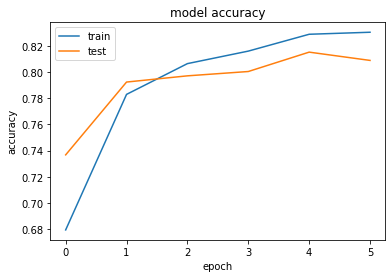

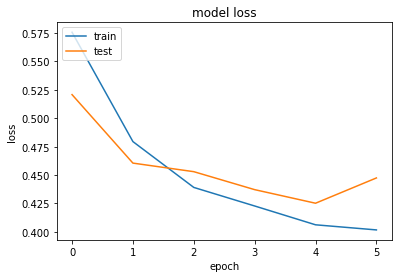

In [76]:
import matplotlib.pyplot as plt

#Analyzing model accuracy and loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#A short implementation of the zero rule algorithm to use as a benchmark
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score

def zero_rule_algorithm(train_df, eval_df):
    outputs = [tuple(t) for t in train_df]
    most_common = max(outputs, key = outputs.count)
    return [most_common for i in range(len(eval_df))]
    
predictions = zero_rule_algorithm(y_train, y_test)
values = [tuple(i) for i in y_test]
label_ranking_average_precision_score(values, predictions)